# 快速入门：ShuffleNetV1网络迁移推理可视化

本文以ShuffleNetV1为网络模型，在mindspore CPU平台上实现迁移flower-photos数据集的推理可视化

## 导入包

In [1]:
from src.model_utils.config import config
from src.dataset import create_flower_dataset
from src.shufflenetv1 import ShuffleNetV1
from src.crossentropysmooth import CrossEntropySmooth
from mindspore import Tensor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.model import Model
from mindspore import nn

import time
import numpy as np
import matplotlib.pyplot as plt


{'enable_modelarts': 'Whether training on modelarts default: False', 'data_url': 'Url for modelarts', 'train_url': 'Url for modelarts', 'data_path': 'The location of input data', 'output_pah': 'The location of the output file', 'device_target': 'device id of GPU or Ascend. (Default: None)', 'enable_profiling': 'Whether enable profiling while training default: False', 'is_distributed': 'distributed training', 'resume': 'resume training with existed checkpoint', 'model_size': 'shuffleNetV1 model size choices 2.0x, 1.5x, 1.0x, 0.5x', 'device_id': 'device id', 'file_name': 'output file name', 'file_format': 'file format choices [AIR MINDIR ONNX]'}
{'amp_level': 'O0',
 'batch_size': 128,
 'checkpoint_url': '',
 'ckpt_path': './ckpt/shufflenetv1-best.ckpt',
 'config_path': 'E:\\workspace\\shufflenetv1\\src\\model_utils\\../../transfer_config.yaml',
 'data_path': '',
 'data_url': '',
 'dataset_path': '../flower_photos/',
 'decay_method': 'cosine',
 'device_id': 0,
 'device_target': 'CPU',
 'e

## 处理数据集

数据集将划分80%用于训练，20%用于验证。

> 你可以从[数据集下载页面](https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz)下载，解压后按下方目录结构放置。


In [2]:
train_dataset, eval_dataset = create_flower_dataset()

下载的数据集文件的目录结构如下：

```text
./flower_photos/
├── daisy
├── dandelion
├── roses
├── sunflowers
└── tulips
```

## 创建模型

创建ShuffleNetV1模型（[参考文献](https://arxiv.org/pdf/1707.01083.pdf)）
定义网络模型如下：

In [3]:
net = ShuffleNetV1(model_size=config.model_size, n_class=config.num_classes)

model size is  2.0x


## 定义损失函数

要验证神经网络模型，需要定义损失函数。

- 损失函数这里使用`CrossEntropySmooth`。

In [4]:
# 定义损失函数
loss = CrossEntropySmooth(sparse=True, reduction="mean", smooth_factor=config.label_smooth_factor,
                          num_classes=config.num_classes)

## 模型推理

1. 使用`model.eval`接口读入测试数据集。
2. 使用保存后的模型参数进行推理。

In [5]:
param_dict = load_checkpoint(config.ckpt_path)
load_param_into_net(net, param_dict)
net.set_train(False)

eval_metrics = {'Loss': nn.Loss(), 'Top_1_Acc': nn.Top1CategoricalAccuracy()}
model = Model(net, loss_fn=loss, metrics=eval_metrics)

start_time = time.time()
res = model.eval(eval_dataset, dataset_sink_mode=False)
use_time = time.time() - start_time
hour = str(int(use_time // 60 // 60))
minute = str(int(use_time // 60 % 60))
second = str(int(use_time % 60))
log = "result:" + str(res) + ", ckpt:'" + config.ckpt_path + "', time: " + hour + "h " + minute + "m " + second + "s"
print(log)

result:{'Loss': 0.5908931970596314, 'Top_1_Acc': 0.94375}, ckpt:'./ckpt/shufflenetv1-best.ckpt', time: 0h 0m 16s


可以在打印信息中看出模型精度数据，示例中精度数据达到95%以上，模型质量良好。本模型迭代100次，随着网络迭代次数增加，模型精度会进一步提高。

## 可视化

我们使用生成的模型进行单个图片数据的分类预测。
> - 代码使用了Tensor模块，阅读更多有关[张量Tensor](https://www.mindspore.cn/tutorials/zh-CN/r1.7/beginner/tensor.html)的信息。

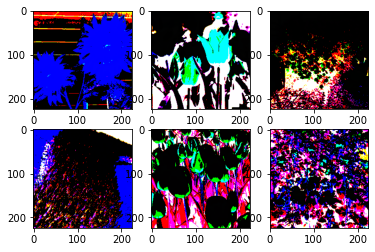

Predicted: "[3 4 2 4 4 2]",
Actual   : "[3 4 2 4 4 2]".


In [6]:
ds_test = eval_dataset.create_dict_iterator()
data = next(ds_test)
images = []
labels = []
plt.figure()
for i in range(1, 7):
    image = data["image"].asnumpy()[i]
    label = data["label"].asnumpy()[i]
    plt.subplot(2, 3, i)
    plt.imshow(np.transpose(image, (1, 2, 0)).astype('uint8'))
    images.append(image)
    labels.append(label)
plt.show()

# 使用函数model.predict预测image对应分类
output = model.predict(Tensor(images))
predicted = np.argmax(output.asnumpy(), axis=1)

# 输出预测分类与实际分类
print(f'Predicted: "{predicted}",\nActual   : "{np.array(labels)}".')

# 从上面的打印结果可以看出，预测值与目标值完全一致。

从上面的打印结果可以看出，预测值与目标值完全一致。